In [ ]:
!unzip /content/gdrive/"My Drive"/cell-images-for-detecting-malaria.zip


Streaming output truncated to the last 5000 lines.
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
  inflating: cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
  inflating: cell_im

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
img_dir='/content/cell_images/cell_images/'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader,Subset
from torchvision import models,transforms,datasets

In [ ]:
gpu_yes = torch.cuda.is_available()

if gpu_yes:
    print('GPU is ready.')
else:
    print('No GPU found. Using CPU.')

GPU is ready.


In [ ]:
#loading data 
batch_size  = 32

data_dir =img_dir

#define data transformation 
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomRotation(30),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])


trainset = datasets.ImageFolder(data_dir, transform = train_transform)
validset = datasets.ImageFolder(data_dir, transform = test_transform)
testset = datasets.ImageFolder(data_dir, transform = test_transform)

#randomly spliting the data into training set, validation set, and test set
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor((0.7 * num_train)))
valid_split = int(np.floor((num_train-split)*0.5))

train_idx = indices[:split]
valid_idx = indices[split:(split+valid_split)]
test_idx = indices[(split+valid_split):]

#loading the data based on the split index
trainset = Subset(trainset, train_idx)
validset = Subset(validset, valid_idx)
testset = Subset(testset,test_idx)

trainloader = DataLoader(trainset,  batch_size = batch_size, num_workers=0)
validloader = DataLoader(validset,  batch_size = batch_size, num_workers=0)
testloader = DataLoader(testset,  batch_size = batch_size,drop_last=True, num_workers=0)


FileNotFoundError: ignored

In [ ]:
#loading the pretrained model 
model = models.vgg16(pretrained = True)

#Freeze the parameters for the model
for param in model.parameters():
    param.requires_grad = False

#view all the layer on VGG16 
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [ ]:
#define the classifier 
class Classifier(nn.Module):
    
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.hidden1 = nn.Linear(25088,4096)
        self.hidden2 = nn.Linear(4096, 4096)
        self.output = nn.Linear(4096, 2)
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        
        x = self.dropout(F.relu(self.hidden1(x)))
        x = self.dropout(F.relu(self.hidden2(x)))
        x = self.output(x)
        
        return x

In [ ]:
#replace the model's default 
model.classifier = Classifier()

print(model)

#
if gpu_yes:
    model.cuda()

#define the lost function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr = 0.001, momentum = 0.9)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
#training the model

epoches = 10

valid_loss_min = np.Inf

torch.cuda.manual_seed_all(56)

for epoch in range(1,epoches+1):
    
    train_loss = 0.0
    valid_loss = 0.0
    
    #training pharse
    model.train()
    for data, target in trainloader:
        
        if gpu_yes:
            data, target = data.cuda(), target.cuda()
            
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
    
    #validation pharse
    model.eval()
    with torch.no_grad():
        for data, target in validloader:
            
            if gpu_yes:
                data, target = data.cuda(), target.cuda()
                
            output = model(data)
            loss = criterion(output, target)

            valid_loss += loss.item()*data.size(0)
            
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(validloader.dataset)
    
    #print out the loss and save the model if the validation loss decreases
    print('Epoch: {}\tTraining  Loss : {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}. Saving model...)'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
        
        

Epoch: 1	Training  Loss : 0.519670 	Validation Loss: 0.244179
Validation loss decreased (inf --> 0.244179. Saving model...)
Epoch: 2	Training  Loss : 0.438315 	Validation Loss: 0.217107
Validation loss decreased (0.244179 --> 0.217107. Saving model...)
Epoch: 3	Training  Loss : 0.415432 	Validation Loss: 0.196815
Validation loss decreased (0.217107 --> 0.196815. Saving model...)
Epoch: 4	Training  Loss : 0.407959 	Validation Loss: 0.196958
Epoch: 5	Training  Loss : 0.396108 	Validation Loss: 0.194092
Validation loss decreased (0.196815 --> 0.194092. Saving model...)
Epoch: 6	Training  Loss : 0.392155 	Validation Loss: 0.186212
Validation loss decreased (0.194092 --> 0.186212. Saving model...)
Epoch: 7	Training  Loss : 0.389084 	Validation Loss: 0.181385
Validation loss decreased (0.186212 --> 0.181385. Saving model...)
Epoch: 8	Training  Loss : 0.389054 	Validation Loss: 0.192596
Epoch: 9	Training  Loss : 0.382968 	Validation Loss: 0.188430
Epoch: 10	Training  Loss : 0.384413 	Validati

In [ ]:
#loading the optimized model from the the training session
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
#define the categories the dataset contains
cat_to_name = ['Parasitized','Uninfected']

In [ ]:

test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
model.eval()
with torch.no_grad():
    for data, target in testloader:
        if gpu_yes:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        #print(target.data[1])

        loss = criterion(output,target)
        test_loss += loss.item()*data.size(0)

        _, pred = torch.max(output, 1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not gpu_yes else np.squeeze(
                             correct_tensor.cpu().numpy())

        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' %(
              cat_to_name[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Acccuracy of %5s: N/A (no training example)' %
             (cat_to_name[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
       100 *np.sum(class_correct) / np.sum(class_total),
       np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.190826

Test Accuracy of Parasitized: 90% (1864/2053)
Test Accuracy of Uninfected: 94% (1964/2075)

Test Accuracy (Overall): 92% (3828/4128)


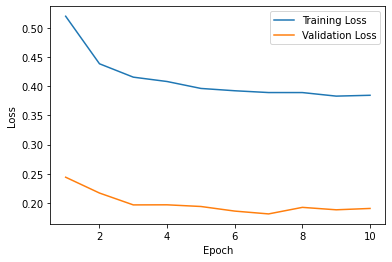

In [ ]:
import matplotlib.pyplot as plt 
  
# line 1 points 
y1 = [0.519670,0.438315,0.415432, 0.407959,0.396108,0.392155,0.389084,0.389054,0.382968,0.384413] 
x1 = [1,2,3,4,5,6,7,8,9,10] 
# plotting the line 1 points  
plt.plot(x1, y1, label = "Training Loss") 
  
# line 2 points 
x2 = [1,2,3,4,5,6,7,8,9,10] 
y2 = [0.244179,0.217107,0.196815,0.196958,0.194092,0.186212,0.181385,0.192596,0.188430,0.190739] 
# plotting the line 2 points  
plt.plot(x2, y2, label = "Validation Loss") 
  
# naming the x axis 
plt.xlabel('Epoch') 
# naming the y axis 
plt.ylabel('Loss') 
  
# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show() 

In [ ]:
#loading the pretrained model 
model = models.vgg19(pretrained = True)

#Freeze the parameters for the model
for param in model.parameters():
    param.requires_grad = False

#view all the layer on VGG19 
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
#replace the model's default 
model.classifier = Classifier()

print(model)

#
if gpu_yes:
    model.cuda()

#define the lost function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr = 0.001, momentum = 0.9)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [45]:
#training the model

epoches = 10

valid_loss_min = np.Inf
xs=[]
ys=[]
torch.cuda.manual_seed_all(56)

for epoch in range(1,epoches+1):
    
    train_loss = 0.0
    valid_loss = 0.0
    
    #training pharse
    model.train()
    for data, target in trainloader:
        
        if gpu_yes:
            data, target = data.cuda(), target.cuda()
            
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
    
    #validation pharse
    model.eval()
    with torch.no_grad():
        for data, target in validloader:
            
            if gpu_yes:
                data, target = data.cuda(), target.cuda()
                
            output = model(data)
            loss = criterion(output, target)

            valid_loss += loss.item()*data.size(0)
            
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(validloader.dataset)
    xs.append(train_loss)
    ys.append(valid_loss)
    #print out the loss and save the model if the validation loss decreases
    print('Epoch: {}\tTraining  Loss : {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}. Saving model...)'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
        
        

Epoch: 1	Training  Loss : 0.368390 	Validation Loss: 0.202388
Validation loss decreased (inf --> 0.202388. Saving model...)
Epoch: 2	Training  Loss : 0.375559 	Validation Loss: 0.184800
Validation loss decreased (0.202388 --> 0.184800. Saving model...)
Epoch: 3	Training  Loss : 0.374460 	Validation Loss: 0.194257
Epoch: 4	Training  Loss : 0.368414 	Validation Loss: 0.193492
Epoch: 5	Training  Loss : 0.370428 	Validation Loss: 0.191359
Epoch: 6	Training  Loss : 0.369407 	Validation Loss: 0.189218
Epoch: 7	Training  Loss : 0.369920 	Validation Loss: 0.190072
Epoch: 8	Training  Loss : 0.368402 	Validation Loss: 0.197825
Epoch: 9	Training  Loss : 0.363685 	Validation Loss: 0.181866
Validation loss decreased (0.184800 --> 0.181866. Saving model...)
Epoch: 10	Training  Loss : 0.366421 	Validation Loss: 0.190959


In [46]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
#define the categories the dataset contains
cat_to_name = ['Parasitized','Uninfected']

In [48]:

test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
with torch.no_grad():
    for data, target in testloader:
        if gpu_yes:
            data, target = data.cuda(), target.cuda()

        output = model(data)
        #print(target.data[1])

        loss = criterion(output,target)
        test_loss += loss.item()*data.size(0)

        _, pred = torch.max(output, 1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not gpu_yes else np.squeeze(
                             correct_tensor.cpu().numpy())

        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' %(
              cat_to_name[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Acccuracy of %5s: N/A (no training example)' %
             (cat_to_name[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
       100 *np.sum(class_correct) / np.sum(class_total),
       np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.186976

Test Accuracy of Parasitized: 90% (1860/2053)
Test Accuracy of Uninfected: 95% (1979/2075)

Test Accuracy (Overall): 92% (3839/4128)


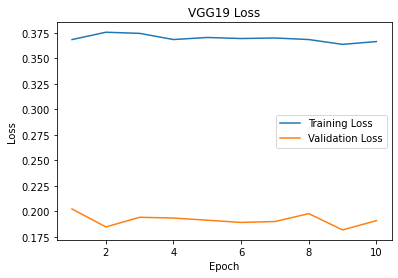

In [50]:
import matplotlib.pyplot as plt 
  
# line 1 points 
y1 = xs 
x1 = [1,2,3,4,5,6,7,8,9,10] 
# plotting the line 1 points  
plt.plot(x1, y1, label = "Training Loss") 
  
# line 2 points 
x2 = [1,2,3,4,5,6,7,8,9,10] 
y2 = ys
# plotting the line 2 points  
plt.plot(x2, y2, label = "Validation Loss") 
  
# naming the x axis 
plt.xlabel('Epoch') 
# naming the y axis 
plt.ylabel('Loss') 
plt.title('VGG19 Loss')  
# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show() 